# Phase 1 — Data Preprocessing & Exploratory Data Analysis (EDA)


In [18]:
# Importing libraries and create folders for saving outputs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import joblib

os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)


In [19]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


path = "/content/drive/MyDrive/heart_disease.csv"


df = pd.read_csv(path)
print("Loaded:", path)
print("Shape:", df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded: /content/drive/MyDrive/heart_disease.csv
Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [20]:
#  Check for missing values in each column
df.isnull().sum()


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [21]:
#  Identify numeric and categorical columns
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
if "target" in num_cols:
    num_cols.remove("target")

cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Categorical columns: []


In [22]:
#   Build preprocessing pipelines
# - Numeric features: fill missing with median, then scale
# - Categorical features: fill missing with most frequent, then one-hot encode
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine into a ColumnTransformer
if len(cat_cols) > 0:
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols)
        ]
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols)
        ]
    )


In [23]:
#  Apply preprocessing pipeline to dataset
X = df.drop(columns=["target"])
y = df["target"]

X_processed = preprocessor.fit_transform(X)

# Get feature names after transformation
try:
    ohe_features = preprocessor.named_transformers_["cat"]["encoder"].get_feature_names_out(cat_cols)
except Exception:
    ohe_features = np.array([])

all_features = np.concatenate([num_cols, ohe_features]) if len(ohe_features)>0 else np.array(num_cols)

# Convert to DataFrame
if hasattr(X_processed, "toarray"):
    X_arr = X_processed.toarray()
else:
    X_arr = X_processed

df_cleaned = pd.DataFrame(X_arr, columns=all_features)
df_cleaned["target"] = y.values

print("Cleaned dataset shape:", df_cleaned.shape)
df_cleaned.head()


Cleaned dataset shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.948726,0.686202,-2.251775,0.757525,-0.264900,2.394438,1.016684,0.017197,-0.696631,1.087338,2.274579,-0.711131,0.660004,0
1,1.392002,0.686202,0.877985,1.611220,0.760415,-0.417635,1.016684,-1.821905,1.435481,0.397182,0.649113,2.504881,-0.890238,2
2,1.392002,0.686202,0.877985,-0.665300,-0.342283,-0.417635,1.016684,-0.902354,1.435481,1.346147,0.649113,1.432877,1.176752,1
3,-1.932564,0.686202,-0.165268,-0.096170,0.063974,-0.417635,-0.996749,1.637359,-0.696631,2.122573,2.274579,-0.711131,-0.890238,0
4,-1.489288,-1.457296,-1.208521,-0.096170,-0.825922,-0.417635,1.016684,0.980537,-0.696631,0.310912,-0.976352,-0.711131,-0.890238,0


In [24]:
#  Save cleaned dataset and preprocessing pipeline
df_cleaned.to_csv("data/heart_disease_cleaned.csv", index=False)
joblib.dump(preprocessor, "models/preprocessor_pipeline.pkl")

print("Saved cleaned dataset and pipeline.")


Saved cleaned dataset and pipeline.


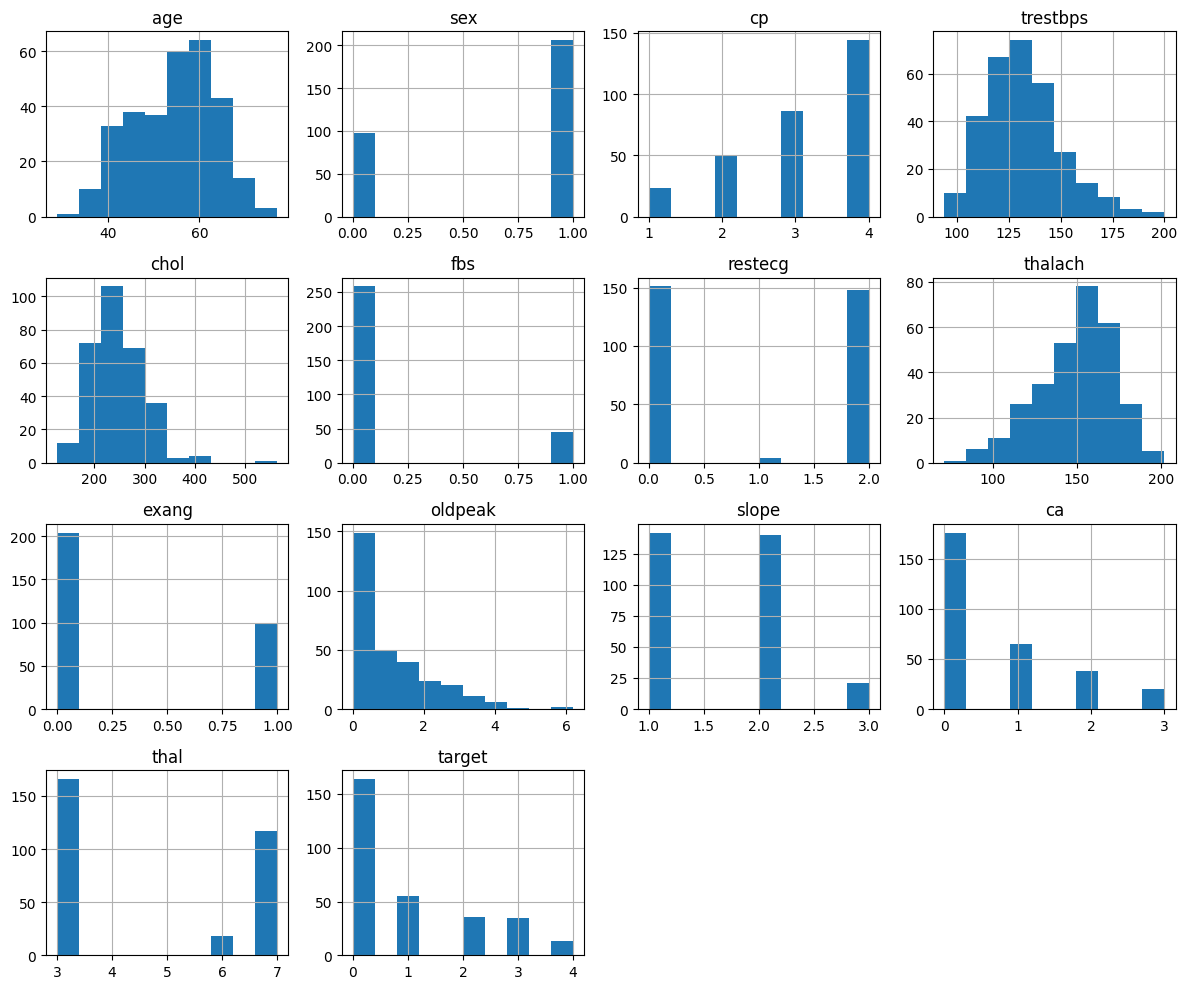

In [25]:
#  Histograms to see feature distributions
df.hist(figsize=(12,10))
plt.tight_layout()
plt.show()


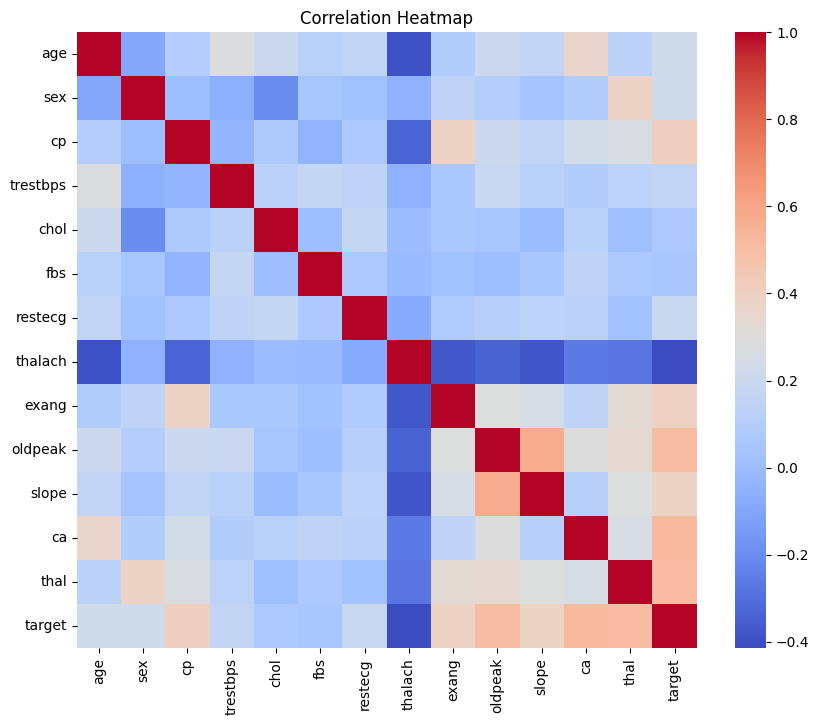

In [26]:
#  Correlation heatmap to explore feature relationships
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


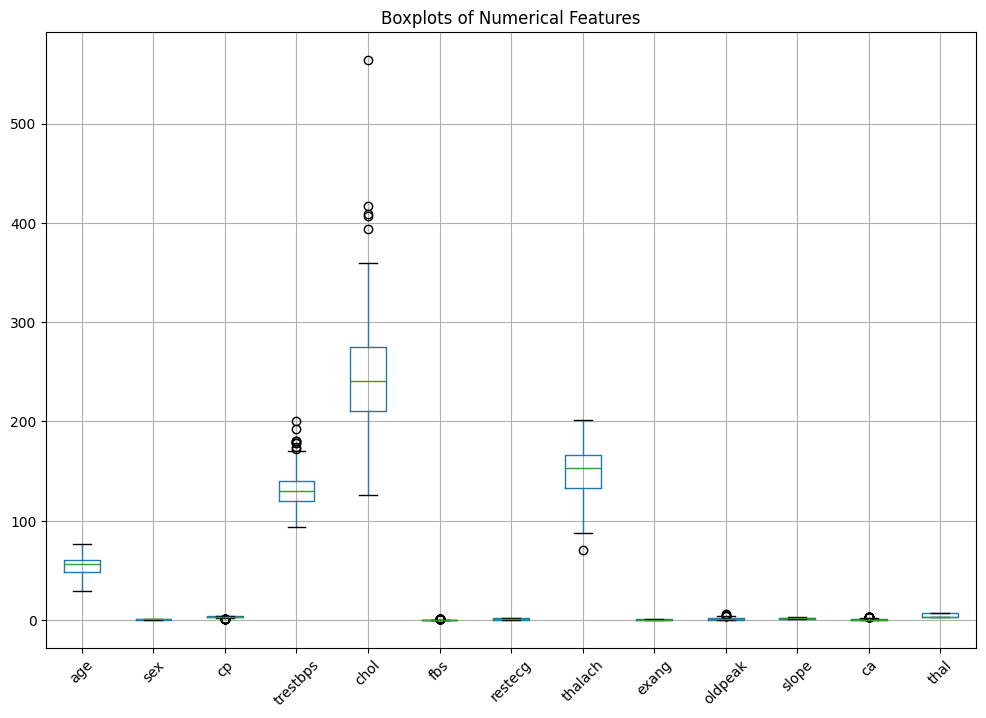

In [27]:
#  Boxplots to detect outliers in numeric features
plt.figure(figsize=(12,8))
df[num_cols].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplots of Numerical Features")
plt.show()
